In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import squarify
import matplotlib.text
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib.ticker as mtick
import os

%matplotlib inline

### Load data and setup pyplot subplots

In [20]:
# Read
review_df = pd.read_csv("Data/review_data_1.csv", header=0, index_col=0)
review_df['group_folder'] = review_df['group_folder'].replace({'Drone-assisted studies':'Drone-based studies'})


# Get the count of code_lev2 for each combination of code and scenario
review_df['Number of papers'] = review_df.groupby(['code_lev1','code_lev2', 'group_folder'])['code_lev2'].transform('size')
review_df["Occurrence in papers (%)"] = review_df['Number of papers'] / review_df["Total papers of scenario"] * 100


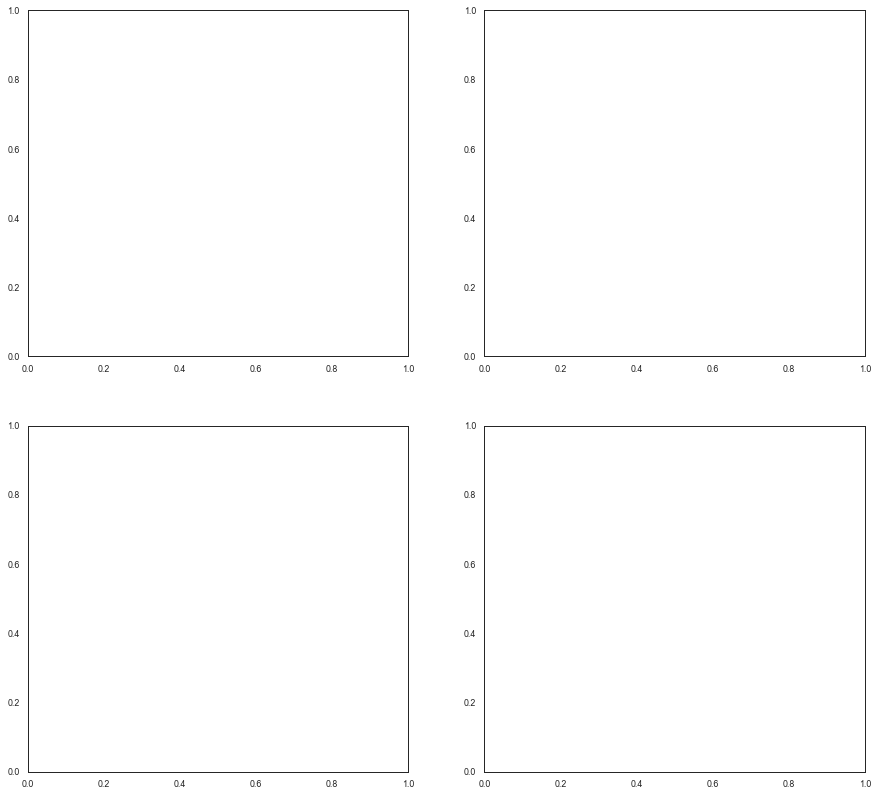

In [21]:
# create map axis object
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
fig, axs = plt.subplots(2, 2, figsize=(15,14), sharex=False, sharey=False)

### Panel 1: Publications by Year

In [22]:
# Read
years_df = pd.read_csv("Years_paper.csv", header=0)

# Wrangle
years_field = years_df.groupby(['Field-based'], as_index=False)['Drone-based'].count().rename(columns={'Field-based':'year',
                                                                                 'Drone-based':'count'})
years_field['approach'] = 'Field-based studies'
years_drone = years_df.groupby(['Drone-based'], as_index=False)['Field-based'].count().rename(columns={'Drone-based':'year',
                                                                                 'Field-based':'count'})
years_drone['approach'] = 'Drone-based studies'
years_df = pd.concat([years_field,years_drone])

# Print
years_df['count'] = years_df['count'].astype('int')
years_df['year'] = years_df['year'].astype('int')
years_df.head()


,year,count,approach
0,2012,1,Field-based studies
1,2013,4,Field-based studies
2,2014,2,Field-based studies
3,2016,3,Field-based studies
4,2017,3,Field-based studies


In [23]:
# Do the plotting
cmap = {'Drone-based studies':"#3182bd", "Field-based studies":"#238b45"}
sns.set_color_codes("muted")
sns.barplot(years_df, x="year", y="count", hue="approach", ax=axs[0,0], palette=cmap, dodge=True)

# Add horizontal gray lines at every x-tick
axs[0,0].set_yticks([1,2,3,4,5,6])
axs[0,0].yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

# Change styling
axs[0,0].set_ylabel("Number of publications", fontdict={'fontsize': 12})
axs[0,0].set_xlabel(None)
axs[0,0].tick_params(labelsize=12)
axs[0,0].legend().remove()

sns.despine(left=False, bottom=False)

<Figure size 432x288 with 0 Axes>

### Panel 3: Ecosystem Attributes accross publications

In [24]:

#########################################################
#########################################################
### Percentage of papers that describes each attribute -- Plot with Seaborn ###
order = review_df.loc[(review_df['group_folder']=='Drone-based studies')&(review_df['code_lev1']=='ATTR (Ecosystem attributes covered by information)')].drop_duplicates().sort_values("Occurrence in papers (%)", ascending=False)['code_lev2'].unique()
review_df_2 = review_df.loc[(review_df['code_lev1']=='ATTR (Ecosystem attributes covered by information)')].drop_duplicates().sort_values(["Occurrence in papers (%)"], ascending=False)


# Plot 
sns.set_color_codes("muted")
sns.barplot(x="Occurrence in papers (%)", y="code_lev2", data=review_df_2,
             hue="group_folder", ax=axs[1,0], palette=cmap,  order=order)#, order=order, palette=cmap)

# Add vertical gray lines at every x-tick
axs[1,0].set_xticks([10,20,30,40,50,60])
axs[1,0].xaxis.grid(color='gray', linestyle='--', linewidth=0.5)

# Remove labels
axs[1,0].set_ylabel(None)
axs[1,0].set_xlabel("Occurrences (%)", fontdict={'fontsize': 12})
axs[1,0].tick_params(labelsize=12)

# Remove legend
axs[1,0].legend().remove()



### Panel 2: Publications by Region

Documentation for drawing bars on map:
* https://stackoverflow.com/questions/73449918/plot-bar-charts-on-a-map-in-plotly
* https://stackoverflow.com/questions/65854228/is-there-a-way-to-overlay-a-bar-chart-matplotlib-onto-a-map-geopandas

In [25]:
# Get continent polygons
continents = gpd.read_file("Z:\\_CanadaLayers\\Globe\\natural_earth_vector\\110m_cultural\\ne_110m_admin_0_countries.shp")
continents = continents.dissolve(by='CONTINENT', as_index=False)

# Get other polygons
graticule = gpd.read_file("Z:\\_CanadaLayers\\Globe\\natural_earth_vector\\ne_110m_graticules_all\\ne_110m_graticules_20.shp")
bbox = gpd.read_file("Z:\\_CanadaLayers\\Globe\\natural_earth_vector\\ne_110m_graticules_all\\ne_110m_wgs84_bounding_box.shp")

# Remove last graticule
graticule=graticule.loc[graticule['degrees']!=180]

# Get data from review
areas_df = review_df.loc[(review_df['code_lev1']=='LOC (Location of ecosites)'),
                         ['code_lev2', 'group_folder', 'Occurrence in papers (%)', 'Total papers of scenario']]

areas_df['code_lev2'] = areas_df['code_lev2'].replace({'Latin America':'South America'})
areas_df.drop_duplicates(inplace=True)
areas_df = areas_df.pivot(index='code_lev2', columns='group_folder', values='Occurrence in papers (%)').reset_index()

# Add coordinates
coords = pd.DataFrame({'North America':(40, -102.5),
 'South America':(-12.5, -67.5),
 'Europe':(53,1),
 'Asia':(37.5,80),
 'Africa':(15,5),
 'Oceania':(-32.5,120)}).T.reset_index().rename(columns={'index':'code_lev2',0:'lat',1:'lon'}) # lat, lon
continents = pd.merge(continents,pd.merge(areas_df, coords), left_on='CONTINENT', right_on='code_lev2')

# File NaN with 0
continents.fillna(0, inplace=True)

# reproject layer to equal earth
ea_proj = '+proj=eqearth +lon_0=0 +datum=WGS84 +units=m +no_defs'
continents = continents.to_crs(ea_proj)
graticule = graticule.to_crs(ea_proj)
bbox = bbox.to_crs(ea_proj)

# remove axes
axs[0,1].axis('off')

# add title
axs[0,1].set_title(None)

# add bounding box and graticule layers
bbox.plot(
    ax = axs[0,1],
    color = 'lightgray',
    linewidth = 0,
    )

# plot the countries
continents.plot(
    ax = axs[0,1],
    edgecolor='none',
    color='darkgray')

# plot the graticules
graticule.plot(
    ax = axs[0,1],
    color = 'gray',
    alpha=0.2)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
for row in continents.iterrows():
    data = row[1]

    ax_bar = inset_axes(axs[0,0], width="100%", height="100%", loc='center', 
                        bbox_to_anchor=(0.5*(1+data['lon']/180), 0.5*(1+data['lat']/90), 0.05, 0.3), 
                        bbox_transform=axs[0,1].transAxes)
    ax_bar.bar([1, 2, ], [data['Drone-based studies'], data['Field-based studies'],], 
               color=["#3182bd", "#238b45"],
               edgecolor='none')
    ax_bar.set_axis_off()
    ax_bar.set_ylim(0,100)

ax_bar = inset_axes(axs[0,0], width="100%", height="100%", loc='center', 
                        bbox_to_anchor=(0.5*(1+0/180), 0.5*(1+-150/90), 0.05, 0.3), 
                        bbox_transform=axs[0,1].transAxes)
ax_bar.bar([1, 2 ], [100, 0], color='gray')
ax_bar.set_ylim(0,100)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.set_xticks([])
ax_bar.set_yticks([0,50,100])
yticks = mtick.FormatStrFormatter('%.0f%%') # Format the ticks, e.g. '40%'
ax_bar.yaxis.set_major_formatter(yticks)
ax_bar.tick_params(axis='y', which='major', pad=-5)


c:\Miniconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1511: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated = aggregated.reset_index()
c:\Miniconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 432x288 with 0 Axes>

### Panel 4: Remote Sensing Technology - Sensor and Spatial Resolution

In [26]:
review_df.loc[review_df['code_lev1']=='SENS (Drone sensor)']

,document_id,snippet_id,snippet,group_folder,code_lev0,code_lev1,code_lev2,Number of papers,Total papers of scenario,Occurrence in papers (%),Total %
0,3D-CNN based UAV hyperspectral imagery for gra...,Reference 1,2.1 cm/pixel,Drone-based studies,GENERAL,SENS (Drone sensor),Hyperspectral,7,53,13.207547,130.188679
1,Identification and Classification of Small Sam...,Reference 1,The instruments used in this study were mainly...,Drone-based studies,GENERAL,SENS (Drone sensor),Hyperspectral,7,53,13.207547,130.188679
2,Monitoring restored tropical forest diversity ...,Reference 1,hyperspectral and lidar fusion,Drone-based studies,GENERAL,SENS (Drone sensor),Hyperspectral,7,53,13.207547,130.188679
3,Object-Based Mangrove Species Classification U...,Reference 1,"A high-spatial-resolution hyperspectral image,...",Drone-based studies,GENERAL,SENS (Drone sensor),Hyperspectral,7,53,13.207547,130.188679
4,UAV lidar and hyperspectral fusion for forest ...,Reference 1,While similar high temporal resolution data mi...,Drone-based studies,GENERAL,SENS (Drone sensor),Hyperspectral,7,53,13.207547,130.188679
...,...,...,...,...,...,...,...,...,...,...,...
62,Using Uncrewed Aerial Vehicles for Identifying...,Reference 1,Up to 5 cm,Drone-based studies,GENERAL,SENS (Drone sensor),RGB,31,53,58.490566,130.188679
63,Using Unmanned Aerial Vehicles to assess the r...,Reference 1,"R=Red, G=Green, B=Blue, RE=red edge, NIR=near ...",Drone-based studies,GENERAL,SENS (Drone sensor),RGB,31,53,58.490566,130.188679
64,Visualizing the Spatiotemporal Trends of Therm...,Reference 1,"A DJI Mavic Pro multicopter UAS (DJI, Shenzhen...",Drone-based studies,GENERAL,SENS (Drone sensor),RGB,31,53,58.490566,130.188679
65,Multisensor data to derive peatland vegetation...,Reference 1,The OOB error gives information about the qual...,Drone-based studies,GENERAL,SENS (Drone sensor),Thermal,2,53,3.773585,130.188679


In [27]:
sensor_df = review_df.loc[review_df['code_lev1']=='SENS (Drone sensor)', ['code_lev2', 'group_folder','Occurrence in papers (%)']].drop_duplicates()

cmap2 = pd.DataFrame({'rank':[1,2,3,4,5], 'colors':['#1d4e71','#276897','#3182bd','#4d99d1','#73afdb']})

sensor_df['rank'] = sensor_df['Occurrence in papers (%)'].rank(ascending=True)
sensor_df = pd.merge(sensor_df, cmap2, how='left')


In [28]:
sensor_df['label'] = sensor_df['code_lev2'] + ' (' + sensor_df['Occurrence in papers (%)'].round(decimals=1).astype(str) +'%)'
treemap = squarify.plot(sizes=sensor_df['Occurrence in papers (%)'], label=sensor_df['label'],
              color=sensor_df['colors'], alpha=0.8, ax=axs[1,1])
for artist in treemap.get_children():
    if isinstance(artist, matplotlib.text.Text):
        artist.set_rotation(90)
        artist.set_fontsize(11)
        artist.set_fontweight('bold')
        artist.set_color('white')
        
axs[1,1].set_xticks([])  # Remove x-axis ticks
axs[1,1].set_yticks([])  # Remove y-axis ticks


[]

### Final plot

In [29]:
sns.despine(ax=axs[0,0])
sns.despine(ax=axs[0,1])
sns.despine(ax=axs[1,0])
sns.despine(ax=axs[1,1], top=True, right=True,left=True,bottom=True)
axs[0,1].set_xlim(-17000000, 17000000)
fig.tight_layout(w_pad=4,h_pad=4)
fig.show()
fig.savefig("Data\Review_panel_plot.tif", dpi=1200)

C:\Users\rnuijten.stu\AppData\Local\Temp/ipykernel_117168/1144388877.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=4,h_pad=4)
C:\Users\rnuijten.stu\AppData\Local\Temp/ipykernel_117168/1144388877.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


### Create multiple plots

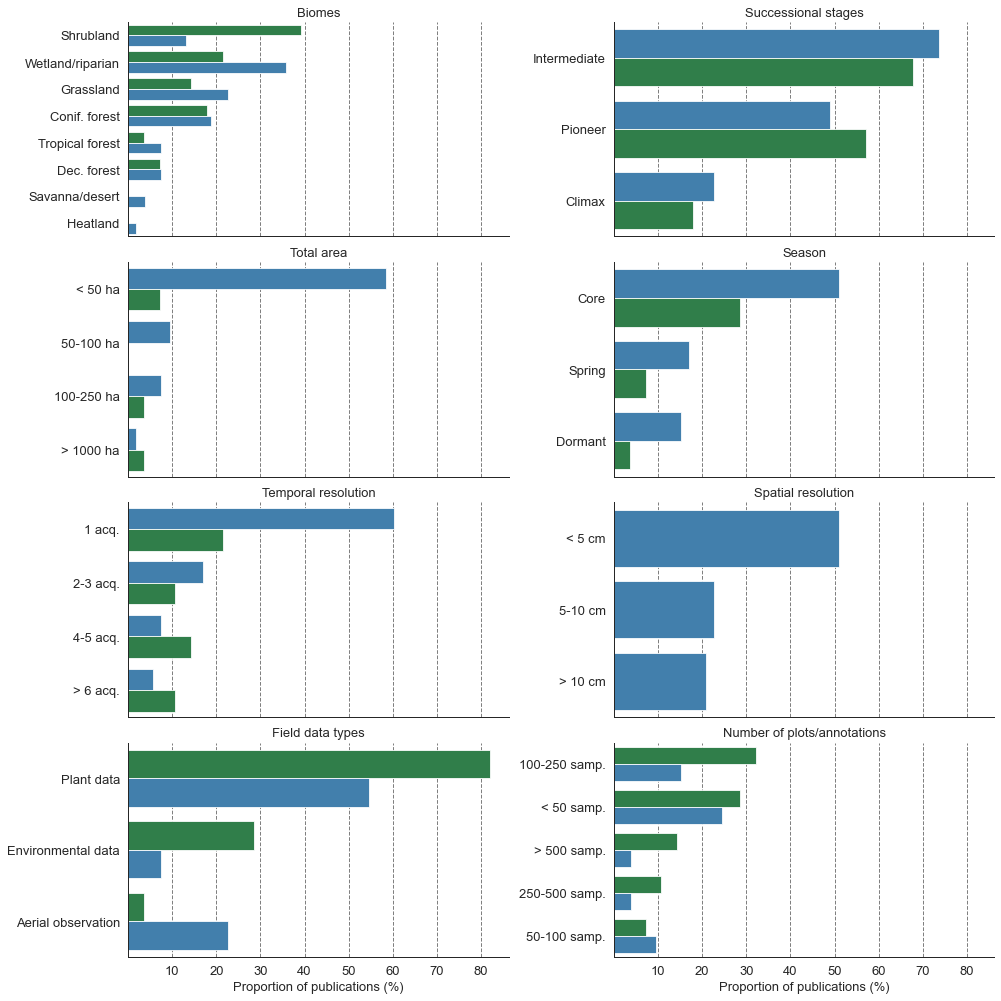

In [30]:
subjects = ['BIOME (Biome of ecosites)','SUCC (Successional stages of ecosites)',
            'AREA (Total area covered)', 'SEAS (Season of data collection)',
            'TEMP (Temporal resolution of information)','RES (Spatial resolution of drone information)',
            'FIELD (Field sampling data)', 'SAMPL (Number of samples)']

titles = ['Biomes', 'Successional stages', 
          'Total area', "Season", 
          'Temporal resolution', "Spatial resolution",
          'Field data types', 'Number of plots/annotations']

cmap = {'Drone-based studies':"#3182bd", "Field-based studies":"#238b45"}

positions = [(0,0), (0,1),
             (1,0), (1,1),
             (2,0), (2,1),
             (3,0), (3,1)]

# create map axis object
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
fig, axs = plt.subplots(4, 2, figsize=(14,14), sharex=True, sharey=False)

for i in range(len(subjects)):
    ax = axs[positions[i][0], positions[i][1]]

    #########################################################
    #########################################################
    ### Percentage of papers that describes each attribute -- Plot with Seaborn ###
    #order = review_df.loc[(review_df['group_folder']=='Drone-based studies')&(review_df['code_lev1']==subjects[i])].drop_duplicates().sort_values("Occurrence in papers (%)", ascending=False)['code_lev2'].unique()
    review_df_2 = review_df.loc[(review_df['code_lev1']==subjects[i])].drop_duplicates().sort_values(["Occurrence in papers (%)"], ascending=False)

    # Plot 
    sns.set_color_codes("muted")
    sns.barplot(x="Occurrence in papers (%)", y="code_lev2", data=review_df_2,
                hue="group_folder", ax=ax, palette=cmap)#, order=order, palette=cmap)

    # Add vertical gray lines at every x-tick
    axs[1,0].set_xticks([10,20,30,40,50,60,70,80])
    ax.xaxis.grid(color='gray', linestyle='--', linewidth=1)

    # Remove labels
    ax.set_title(titles[i], fontdict={'fontsize': 13})
    ax.set_ylabel(None)
    ax.set_xlabel("Proportion of publications (%)", fontdict={'fontsize': 13})
    ax.tick_params(labelsize=13)

    # Remove legend
    ax.legend().remove()

sns.despine()
fig.tight_layout()
fig.savefig("Data\Appendix_S1.tif", dpi=800)
